## I have created an acoustic simulation od sound sources using the MUSIC algorithm in the pyroomacoustics library
The 2 sound sources have been placed in an anechoic room and using a same audio file the direction of both the sound sources has been estimated.

In [79]:
import numpy as np
from pyargus.directionEstimation import *
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import pyroomacoustics as pra
import sounddevice as sd
from scipy.io import wavfile
import scipy.signal as ss
import IPython
import operator
import scipy.linalg as LA

Adding all the parameters for the room and the sound source to simulate 


In [80]:
# Parameters
fs, signal1 = wavfile.read("arctic_a0010.wav")
# Sound clip Settings 
sound_array_path = '8ch_hello_az0_el30_1m_48k.npy'
# Search spaces for DOA module
c = 343.    # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3000]
print(signal1)

[0 0 0 ... 0 0 0]


In [81]:
fs,signal2 = wavfile.read("f1.wav")

print(signal2)

[111 114 115 ...  20  15  13]


In [82]:
IPython.display.Audio(signal1, rate=fs)

Creating a mic array, I have created a circular mic array, working on linear mic array.

### Simulation
Simulate room and add audio from Channel 0 of recording as a point source at 1 m away and 0° azimuth and 30° elevation up from mic array. Perform sound source localization based on simulated received sound.

In [83]:
# Location of mic array center (in meters, from origin)

# We only want one channel (mono) for simulated sound source
channel_for_source = 0
distance = 2
# Create white noise for the room
snr_db = 5.     # Signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2

A room is created using pyroomacoustics room module and the mic array is placed for simulation

In [84]:
# Put simulated microphone array in the middle of the room, on the floor
mic_array = np.array([[0.0, 0.0, 0.0],
                      [0.0, 1.0, 0.0],
                      [0.0, 2.0, 0.0],
                      [0.0, 3.0, 0.0],
                      [0.0, 4.0, 0.0],
                      [1.0, 0.0, 0.0],
                      [2.0, 0.0, 0.0],
                      [3.0, 0.0, 0.0],
                      [4.0, 0.0, 0.0],
                      [1.0, 1.0, 0.0],
                      [1.0, 2.0, 0.0],
                      [1.0, 3.0, 0.0],
                      [1.0, 4.0, 0.0],
                      [2.0, 1.0, 0.0],
                      [2.0, 2.0, 0.0],
                      [2.0, 3.0, 0.0],
                      [2.0, 4.0, 0.0],
                      [3.0, 1.0, 0.0],
                      [3.0, 2.0, 0.0],
                      [3.0, 3.0, 0.0],
                      [3.0, 4.0, 0.0],
                      [4.0, 1.0, 0.0],
                      [4.0, 2.0, 0.0],
                      [4.0, 3.0, 0.0],
                      [4.0, 4.0, 0.0],
                     ])
mic_array /= 2
mic_array = mic_array.T

In [85]:
sample_rate = 160000
# We only want one channel (mono) for simulated sound source
channel_for_source = 0

# Create white noise for the room
snr_db = 5.     # Signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2

/home/aadhar/.local/lib/python3.6/site-packages/pyroomacoustics/room.py:1049: UserWarning: Using absorption parameter is deprecated. In the future, use materials instead.
  "Using absorption parameter is deprecated. In the future, use materials instead."


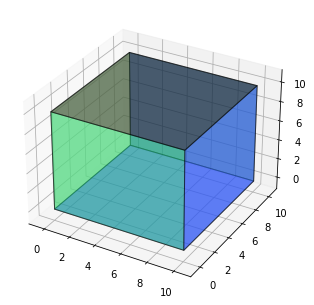

In [86]:
absorption = 1.0
max_order = 0
room_dim = np.array([10., 10.])
room_height = 10.

corners = np.array([[0, 0], [room_dim[0], 0], [room_dim[0], room_dim[1]], [0, room_dim[1]]]).T  # [x,y]
room = pra.Room.from_corners(corners, absorption=absorption, fs=sample_rate, max_order=max_order, sigma2_awgn=sigma2)
room.extrude(room_height)

fig, ax = room.plot()
ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])
ax.set_zlim([-1, 11]);


[-0.00476074 -0.00469971 -0.00497437 ...  0.03005981  0.02719116
  0.02450562]


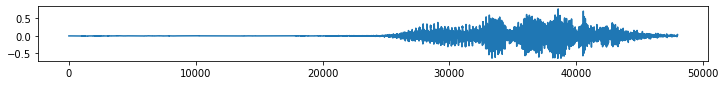

In [87]:
# Play original file
plt.figure(figsize=(12, 1))
plt.plot(signals[channel_for_source])
sd.play(signals[channel_for_source])
print(signals[channel_for_source])

[(0.0, 10.0), (0.0, 10.0), (0.0, 10.0)]

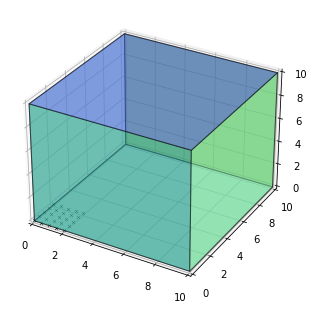

In [88]:
# Put simulated microphone array in the middle of the room, on the floor

mic_loc = mic_array
room.add_microphone_array(pra.MicrophoneArray(mic_loc, room.fs))

# Show the mic array
fig, ax = room.plot()
ax.set(xlim=(0, 10), ylim=(0, 10), zlim=(0.0, 10))

Cartesian coords (x, y, z): [1, 1, 0]


/home/aadhar/.local/lib/python3.6/site-packages/pyroomacoustics/room.py:1838: RuntimeWarning: divide by zero encountered in true_divide
  alpha = src.damping[b, :] / (dist)


[(0.0, 10.0), (0.0, 10.0), (0.0, 10.0)]

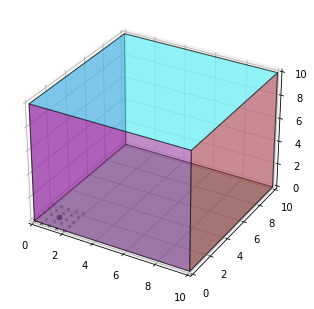

In [89]:
duration_samples = signals.shape[0]

# Convert polar coordinates to Cartesian coordinates
source_location = [1,1,0]
print('Cartesian coords (x, y, z):', source_location)


# Add sound source to room
room.add_source(source_location, signal=signals[0])

# Run room simulation
room.simulate()
fig, ax = room.plot()
ax.set(xlim=(0, 10.0), ylim=(0, 10.0), zlim=(0.0, 10.0))

(25, 48740)


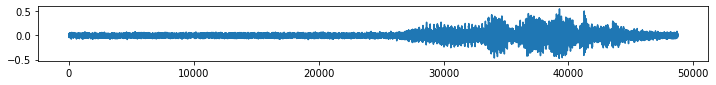

In [90]:
# Play simulated sound as heard by first (center) microphone
plt.figure(figsize=(12, 1))
plt.plot(room.mic_array.signals[0,:])
sd.play(room.mic_array.signals[0,:])
print(room.mic_array.signals.shape)